In [1]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.metrics import mean_absolute_error,mean_squared_error
import numpy as np
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import pickle

In [2]:
from functions.feat_ext import fe_data
from functions.db_connect import return_df

In [3]:
table = return_df()

Connecting to the PostgreSQL database...
Connection successful


In [4]:
df = fe_data(table)

In [5]:
df.head()

,Id,Title,Published_date,Views,Likes,Comments,Duration,Categories,SubCategory,DurationinSeconds,Date,Year,Age
0,V0jlhEAScls,NBA I En İyi Oyunlar,2022-11-04T07:00:11Z,341,14,0,PT1M18S,Basketball,NBA,78,2022-11-04,2022,11
1,EE9j8Vjslcs,Denver Nuggets - Oklahoma City Thunder Maç Öze...,2022-11-04T06:38:33Z,124,4,0,PT1M36S,Basketball,NBA,96,2022-11-04,2022,11
2,2Mo1uJpiBl4,Golden State Warriors - Orlando Magic Maç Özet...,2022-11-04T06:38:30Z,393,7,2,PT2M3S,Basketball,NBA,123,2022-11-04,2022,11
3,vN2q_eycKWw,Olimpia Milano - Real Madrid (77-83) - Maç Öze...,2022-11-03T22:12:26Z,4713,70,8,PT9M9S,Basketball,European_Basketball,549,2022-11-03,2022,12
4,y2mZrITfk7c,Bayern Münih - Anadolu Efes (81-78) - Maç Özet...,2022-11-03T21:48:40Z,22085,299,99,PT8M19S,Basketball,European_Basketball,499,2022-11-03,2022,12


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8680 entries, 0 to 9408
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Id                 8680 non-null   object
 1   Title              8680 non-null   object
 2   Published_date     8680 non-null   object
 3   Views              8680 non-null   int64 
 4   Likes              8680 non-null   int64 
 5   Comments           8680 non-null   int64 
 6   Duration           8680 non-null   object
 7   Categories         8680 non-null   object
 8   SubCategory        8680 non-null   object
 9   DurationinSeconds  8680 non-null   int64 
 10  Date               8680 non-null   object
 11  Year               8680 non-null   object
 12  Age                8680 non-null   int64 
dtypes: int64(5), object(8)
memory usage: 949.4+ KB


In [29]:
df_dummies = pd.get_dummies(df[['Categories','Year','SubCategory']],drop_first=True)

In [30]:
df_one_hot_encoded = pd.concat([df,df_dummies],axis=1)

In [31]:
## CREATE X and y
X = df_one_hot_encoded.drop(['Id','Title','Published_date','Views','Duration'
                             ,'Date','Year','Categories','SubCategory','Age',],axis=1)
y = df_one_hot_encoded['Views']

# TRAIN TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# SCALE DATA
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# ElasticNet

In [42]:
base_elastic_model = ElasticNet()

param_grid = {'alpha':[0.1,0.3,0.5,1],
              'l1_ratio':[.1, .5, .7, .9, .95, 1]}

grid_model = GridSearchCV(estimator=base_elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5)

grid_model.fit(X_train,y_train)

C:\Users\kadir\anaconda3\envs\YT-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89197275547.3706, tolerance: 4851952373.290141
  model = cd_fast.enet_coordinate_descent(
C:\Users\kadir\anaconda3\envs\YT-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 117291444379.56885, tolerance: 5211624737.204379
  model = cd_fast.enet_coordinate_descent(
C:\Users\kadir\anaconda3\envs\YT-env\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 152204999901.67944, tolerance: 5139837141.452211
  model = cd_fast.enet_coordinate_descent(
C:\Users\kadir\anaconda3\envs\YT-env\lib\site-packages\sklearn\linear_mo

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 0.3, 0.5, 1],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 1]},
             scoring='neg_mean_squared_error')

In [43]:
grid_model.best_params_

{'alpha': 0.1, 'l1_ratio': 0.95}

In [44]:
y_pred = grid_model.predict(X_test)

EN_MAE = mean_absolute_error(y_test,y_pred)
EN_MSE = mean_squared_error(y_test,y_pred)
EN_RMSE = np.sqrt(EN_MSE)

print(EN_MAE)
print(EN_RMSE)

8410.351805659418
42129.739361600135


# Support Vector Regression

In [28]:
svr = SVR()
param_grid = {'C':[0.1,0.5,1,2],
              'degree':[2,4,6],
              'epsilon':[0,0.5,1,2]}

grid = GridSearchCV(svr,param_grid=param_grid,cv=5,verbose=2,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] C=0.1, degree=2, epsilon=0 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... C=0.1, degree=2, epsilon=0, total=   2.2s
[CV] C=0.1, degree=2, epsilon=0 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.1s remaining:    0.0s


[CV] ....................... C=0.1, degree=2, epsilon=0, total=   2.0s
[CV] C=0.1, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.1, degree=2, epsilon=0, total=   2.0s
[CV] C=0.1, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.1, degree=2, epsilon=0, total=   2.1s
[CV] C=0.1, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.1, degree=2, epsilon=0, total=   2.1s
[CV] C=0.1, degree=2, epsilon=0.5 ....................................
[CV] ..................... C=0.1, degree=2, epsilon=0.5, total=   2.0s
[CV] C=0.1, degree=2, epsilon=0.5 ....................................
[CV] ..................... C=0.1, degree=2, epsilon=0.5, total=   2.0s
[CV] C=0.1, degree=2, epsilon=0.5 ....................................
[CV] ..................... C=0.1, degree=2, epsilon=0.5, total=   2.1s
[CV] C=0.1, degree=2, epsilon=0.5 ....................................
[CV] .

[CV] ....................... C=0.1, degree=6, epsilon=2, total=   1.9s
[CV] C=0.5, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.5, degree=2, epsilon=0, total=   1.9s
[CV] C=0.5, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.5, degree=2, epsilon=0, total=   1.9s
[CV] C=0.5, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.5, degree=2, epsilon=0, total=   1.9s
[CV] C=0.5, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.5, degree=2, epsilon=0, total=   2.0s
[CV] C=0.5, degree=2, epsilon=0 ......................................
[CV] ....................... C=0.5, degree=2, epsilon=0, total=   2.2s
[CV] C=0.5, degree=2, epsilon=0.5 ....................................
[CV] ..................... C=0.5, degree=2, epsilon=0.5, total=   2.0s
[CV] C=0.5, degree=2, epsilon=0.5 ....................................
[CV] .

[CV] ....................... C=0.5, degree=6, epsilon=2, total=   2.1s
[CV] C=0.5, degree=6, epsilon=2 ......................................
[CV] ....................... C=0.5, degree=6, epsilon=2, total=   2.0s
[CV] C=0.5, degree=6, epsilon=2 ......................................
[CV] ....................... C=0.5, degree=6, epsilon=2, total=   1.9s
[CV] C=1, degree=2, epsilon=0 ........................................
[CV] ......................... C=1, degree=2, epsilon=0, total=   2.0s
[CV] C=1, degree=2, epsilon=0 ........................................
[CV] ......................... C=1, degree=2, epsilon=0, total=   2.1s
[CV] C=1, degree=2, epsilon=0 ........................................
[CV] ......................... C=1, degree=2, epsilon=0, total=   1.9s
[CV] C=1, degree=2, epsilon=0 ........................................
[CV] ......................... C=1, degree=2, epsilon=0, total=   1.9s
[CV] C=1, degree=2, epsilon=0 ........................................
[CV] .

[CV] ......................... C=1, degree=6, epsilon=2, total=   1.9s
[CV] C=1, degree=6, epsilon=2 ........................................
[CV] ......................... C=1, degree=6, epsilon=2, total=   2.2s
[CV] C=1, degree=6, epsilon=2 ........................................
[CV] ......................... C=1, degree=6, epsilon=2, total=   2.2s
[CV] C=1, degree=6, epsilon=2 ........................................
[CV] ......................... C=1, degree=6, epsilon=2, total=   2.4s
[CV] C=1, degree=6, epsilon=2 ........................................
[CV] ......................... C=1, degree=6, epsilon=2, total=   2.1s
[CV] C=2, degree=2, epsilon=0 ........................................
[CV] ......................... C=2, degree=2, epsilon=0, total=   1.9s
[CV] C=2, degree=2, epsilon=0 ........................................
[CV] ......................... C=2, degree=2, epsilon=0, total=   1.9s
[CV] C=2, degree=2, epsilon=0 ........................................
[CV] .

[CV] ......................... C=2, degree=6, epsilon=1, total=   2.0s
[CV] C=2, degree=6, epsilon=1 ........................................
[CV] ......................... C=2, degree=6, epsilon=1, total=   2.1s
[CV] C=2, degree=6, epsilon=2 ........................................
[CV] ......................... C=2, degree=6, epsilon=2, total=   1.9s
[CV] C=2, degree=6, epsilon=2 ........................................
[CV] ......................... C=2, degree=6, epsilon=2, total=   1.9s
[CV] C=2, degree=6, epsilon=2 ........................................
[CV] ......................... C=2, degree=6, epsilon=2, total=   1.9s
[CV] C=2, degree=6, epsilon=2 ........................................
[CV] ......................... C=2, degree=6, epsilon=2, total=   1.9s
[CV] C=2, degree=6, epsilon=2 ........................................
[CV] ......................... C=2, degree=6, epsilon=2, total=   1.9s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  7.9min finished


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 0.5, 1, 2], 'degree': [2, 4, 6],
                         'epsilon': [0, 0.5, 1, 2]},
             scoring='neg_mean_squared_error', verbose=2)

In [32]:
grid.best_params_

{'C': 2, 'degree': 2, 'epsilon': 0}

In [30]:
y_pred = grid.predict(X_test)

SVR_MAE = mean_absolute_error(y_test,y_pred)
SVR_MSE = mean_squared_error(y_test,y_pred)
SVR_RMSE = np.sqrt(SVR_MSE)

print(SVR_MAE)
print(SVR_RMSE)

27272.716979159657
139621.2750675223


# KNN Regression

In [45]:
knn = KNeighborsRegressor()
k_values = list(range(1,20))
param_grid = {'n_neighbors': k_values}
grid = GridSearchCV(knn,param_grid=param_grid,cv=5,verbose=1,scoring='neg_mean_squared_error')
grid.fit(X_train,y_train)

Fitting 5 folds for each of 19 candidates, totalling 95 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:   21.4s finished


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19]},
             scoring='neg_mean_squared_error', verbose=1)

In [46]:
grid.best_params_

{'n_neighbors': 3}

In [47]:
y_pred = grid.predict(X_test)

KNN_MAE = mean_absolute_error(y_test,y_pred)
KNN_MSE = mean_squared_error(y_test,y_pred)
KNN_RMSE = np.sqrt(KNN_MSE)

print(KNN_MAE)
print(KNN_RMSE)

8415.765148566239
57988.378093003994


# Decision Tree Regressor

In [32]:
DTR_model = DecisionTreeRegressor()
DTR_param_grid = {'max_depth':[2,3,4,5,6,7,8],
              'max_leaf_nodes':[2,3,4,5,6,7,8,11,15,20,30,40,42,50],
             }

DTR_grid = GridSearchCV(DTR_model,param_grid=DTR_param_grid,cv=10,verbose=2,scoring='neg_mean_squared_error')
DTR_grid.fit(X_train,y_train)

Fitting 10 folds for each of 98 candidates, totalling 980 fits
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=2 ...................................
[CV] .........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .................... max_depth=2, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .................... max_depth=2, max_leaf_nodes=5, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=5 ...................................
[CV] .

[CV] ................... max_depth=2, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=2, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=2, max_leaf_nodes=20 ..................................
[CV] .

[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=3, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=3 ...................................
[CV] .

[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=3, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=3, max_leaf_nodes=15 ..................................
[CV] .

[CV] .................... max_depth=4, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=4, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=4 ...................................
[CV] .

[CV] ................... max_depth=4, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=4, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=4, max_leaf_nodes=15 ..................................
[CV] .

[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=5, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=2 ...................................
[CV] .

[CV] ................... max_depth=5, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=5, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=5, max_leaf_nodes=15 ..................................
[CV] .

[CV] .................... max_depth=6, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=6, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=3 ...................................
[CV] .

[CV] ................... max_depth=6, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=6, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=6, max_leaf_nodes=15 ..................................
[CV] .

[CV] .................... max_depth=7, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .................... max_depth=7, max_leaf_nodes=4, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=4 ...................................
[CV] .

[CV] ................... max_depth=7, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=15 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=15, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=20 ..................................
[CV] ................... max_depth=7, max_leaf_nodes=20, total=   0.0s
[CV] max_depth=7, max_leaf_nodes=20 ..................................
[CV] .

[CV] .................... max_depth=8, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=2 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=2, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=3 ...................................
[CV] .................... max_depth=8, max_leaf_nodes=3, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=3 ...................................
[CV] .

[CV] .................... max_depth=8, max_leaf_nodes=8, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=11, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=11 ..................................
[CV] .

[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=50 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=50 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=50 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=50 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s
[CV] max_depth=8, max_leaf_nodes=50 ..................................
[CV] ................... max_depth=8, max_leaf_nodes=50, total=   0.0s


[Parallel(n_jobs=1)]: Done 980 out of 980 | elapsed:    9.6s finished


GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8],
                         'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 11, 15, 20, 30,
                                            40, 42, 50]},
             scoring='neg_mean_squared_error', verbose=2)

In [34]:
DTR_grid.best_params_

{'max_depth': 6, 'max_leaf_nodes': 40}

In [35]:
DTR_y_pred = DTR_grid.predict(X_test)

DTR_MAE = mean_absolute_error(y_test,DTR_y_pred)
DTR_MSE = mean_squared_error(y_test,DTR_y_pred)
DTR_RMSE = np.sqrt(DTR_MSE)

print(DTR_MAE)
print(DTR_RMSE)

7471.146274887372
32944.79741073821


# Random Forests

In [36]:
RF_model = RandomForestRegressor()
RF_param_grid = {'n_estimators':[5,10,20,30,50,65,100],
              'max_features': [2,3,4,5,6,7,8,9,10],
              'bootstrap' : [True,False]
             }
RF_grid = GridSearchCV(RF_model,param_grid=RF_param_grid,cv=5,verbose=2,scoring='neg_mean_squared_error')
RF_grid.fit(X_train,y_train)

Fitting 5 folds for each of 126 candidates, totalling 630 fits
[CV] bootstrap=True, max_features=2, n_estimators=5 ..................
[CV] ... bootstrap=True, max_features=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=2, n_estimators=5 ..................
[CV] ... bootstrap=True, max_features=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=2, n_estimators=5 ..................
[CV] ... bootstrap=True, max_features=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=2, n_estimators=5 ..................
[CV] ... bootstrap=True, max_features=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=2, n_estimators=5 ..................
[CV] ... bootstrap=True, max_features=2, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=2, n_estimators=10 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] .. bootstrap=True, max_features=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=20 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=20, total=   0.1s
[CV] bootstrap=True, max_features=2, n_estimators=20 .................
[CV] .. bootstrap=True, max_features=2, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_features=2, n_estimators=20 .................
[CV] .

[CV] .. bootstrap=True, max_features=3, n_estimators=65, total=   0.5s
[CV] bootstrap=True, max_features=3, n_estimators=65 .................
[CV] .. bootstrap=True, max_features=3, n_estimators=65, total=   0.5s
[CV] bootstrap=True, max_features=3, n_estimators=100 ................
[CV] . bootstrap=True, max_features=3, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_features=3, n_estimators=100 ................
[CV] . bootstrap=True, max_features=3, n_estimators=100, total=   0.8s
[CV] bootstrap=True, max_features=3, n_estimators=100 ................
[CV] . bootstrap=True, max_features=3, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_features=3, n_estimators=100 ................
[CV] . bootstrap=True, max_features=3, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_features=3, n_estimators=100 ................
[CV] . bootstrap=True, max_features=3, n_estimators=100, total=   0.7s
[CV] bootstrap=True, max_features=4, n_estimators=5 ..................
[CV] .

[CV] .. bootstrap=True, max_features=5, n_estimators=30, total=   0.2s
[CV] bootstrap=True, max_features=5, n_estimators=30 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=5, n_estimators=30 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=30, total=   0.2s
[CV] bootstrap=True, max_features=5, n_estimators=30 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=30, total=   0.2s
[CV] bootstrap=True, max_features=5, n_estimators=50 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_features=5, n_estimators=50 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_features=5, n_estimators=50 .................
[CV] .. bootstrap=True, max_features=5, n_estimators=50, total=   0.4s
[CV] bootstrap=True, max_features=5, n_estimators=50 .................
[CV] .

[CV] ... bootstrap=True, max_features=7, n_estimators=5, total=   0.0s
[CV] bootstrap=True, max_features=7, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=7, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=7, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=7, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=7, n_estimators=10 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=10, total=   0.1s
[CV] bootstrap=True, max_features=7, n_estimators=20 .................
[CV] .. bootstrap=True, max_features=7, n_estimators=20, total=   0.2s
[CV] bootstrap=True, max_features=7, n_estimators=20 .................
[CV] .

[CV] .. bootstrap=True, max_features=8, n_estimators=65, total=   0.7s
[CV] bootstrap=True, max_features=8, n_estimators=65 .................
[CV] .. bootstrap=True, max_features=8, n_estimators=65, total=   0.7s
[CV] bootstrap=True, max_features=8, n_estimators=65 .................
[CV] .. bootstrap=True, max_features=8, n_estimators=65, total=   0.6s
[CV] bootstrap=True, max_features=8, n_estimators=100 ................
[CV] . bootstrap=True, max_features=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_features=8, n_estimators=100 ................
[CV] . bootstrap=True, max_features=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_features=8, n_estimators=100 ................
[CV] . bootstrap=True, max_features=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_features=8, n_estimators=100 ................
[CV] . bootstrap=True, max_features=8, n_estimators=100, total=   0.9s
[CV] bootstrap=True, max_features=8, n_estimators=100 ................
[CV] .

[CV] . bootstrap=True, max_features=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=10, n_estimators=30 ................
[CV] . bootstrap=True, max_features=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=10, n_estimators=30 ................
[CV] . bootstrap=True, max_features=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=10, n_estimators=30 ................
[CV] . bootstrap=True, max_features=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=10, n_estimators=30 ................
[CV] . bootstrap=True, max_features=10, n_estimators=30, total=   0.3s
[CV] bootstrap=True, max_features=10, n_estimators=50 ................
[CV] . bootstrap=True, max_features=10, n_estimators=50, total=   0.5s
[CV] bootstrap=True, max_features=10, n_estimators=50 ................
[CV] . bootstrap=True, max_features=10, n_estimators=50, total=   0.5s
[CV] bootstrap=True, max_features=10, n_estimators=50 ................
[CV] .

[CV] .. bootstrap=False, max_features=3, n_estimators=5, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=5 .................
[CV] .. bootstrap=False, max_features=3, n_estimators=5, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=10 ................
[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=10 ................
[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=10 ................
[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=10 ................
[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=10 ................
[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.1s
[CV] bootstrap=False, max_features=3, n_estimators=20 ................
[CV] .

[CV] . bootstrap=False, max_features=4, n_estimators=65, total=   0.8s
[CV] bootstrap=False, max_features=4, n_estimators=65 ................
[CV] . bootstrap=False, max_features=4, n_estimators=65, total=   0.9s
[CV] bootstrap=False, max_features=4, n_estimators=65 ................
[CV] . bootstrap=False, max_features=4, n_estimators=65, total=   0.7s
[CV] bootstrap=False, max_features=4, n_estimators=65 ................
[CV] . bootstrap=False, max_features=4, n_estimators=65, total=   0.7s
[CV] bootstrap=False, max_features=4, n_estimators=100 ...............
[CV]  bootstrap=False, max_features=4, n_estimators=100, total=   1.2s
[CV] bootstrap=False, max_features=4, n_estimators=100 ...............
[CV]  bootstrap=False, max_features=4, n_estimators=100, total=   1.2s
[CV] bootstrap=False, max_features=4, n_estimators=100 ...............
[CV]  bootstrap=False, max_features=4, n_estimators=100, total=   1.2s
[CV] bootstrap=False, max_features=4, n_estimators=100 ...............
[CV]  

[CV] . bootstrap=False, max_features=6, n_estimators=20, total=   0.2s
[CV] bootstrap=False, max_features=6, n_estimators=30 ................
[CV] . bootstrap=False, max_features=6, n_estimators=30, total=   0.4s
[CV] bootstrap=False, max_features=6, n_estimators=30 ................
[CV] . bootstrap=False, max_features=6, n_estimators=30, total=   0.4s
[CV] bootstrap=False, max_features=6, n_estimators=30 ................
[CV] . bootstrap=False, max_features=6, n_estimators=30, total=   0.4s
[CV] bootstrap=False, max_features=6, n_estimators=30 ................
[CV] . bootstrap=False, max_features=6, n_estimators=30, total=   0.4s
[CV] bootstrap=False, max_features=6, n_estimators=30 ................
[CV] . bootstrap=False, max_features=6, n_estimators=30, total=   0.4s
[CV] bootstrap=False, max_features=6, n_estimators=50 ................
[CV] . bootstrap=False, max_features=6, n_estimators=50, total=   0.6s
[CV] bootstrap=False, max_features=6, n_estimators=50 ................
[CV] .

[CV] .. bootstrap=False, max_features=8, n_estimators=5, total=   0.1s
[CV] bootstrap=False, max_features=8, n_estimators=5 .................
[CV] .. bootstrap=False, max_features=8, n_estimators=5, total=   0.1s
[CV] bootstrap=False, max_features=8, n_estimators=5 .................
[CV] .. bootstrap=False, max_features=8, n_estimators=5, total=   0.1s
[CV] bootstrap=False, max_features=8, n_estimators=10 ................
[CV] . bootstrap=False, max_features=8, n_estimators=10, total=   0.2s
[CV] bootstrap=False, max_features=8, n_estimators=10 ................
[CV] . bootstrap=False, max_features=8, n_estimators=10, total=   0.2s
[CV] bootstrap=False, max_features=8, n_estimators=10 ................
[CV] . bootstrap=False, max_features=8, n_estimators=10, total=   0.2s
[CV] bootstrap=False, max_features=8, n_estimators=10 ................
[CV] . bootstrap=False, max_features=8, n_estimators=10, total=   0.2s
[CV] bootstrap=False, max_features=8, n_estimators=10 ................
[CV] .

[CV] . bootstrap=False, max_features=9, n_estimators=65, total=   1.3s
[CV] bootstrap=False, max_features=9, n_estimators=65 ................
[CV] . bootstrap=False, max_features=9, n_estimators=65, total=   1.2s
[CV] bootstrap=False, max_features=9, n_estimators=65 ................
[CV] . bootstrap=False, max_features=9, n_estimators=65, total=   1.1s
[CV] bootstrap=False, max_features=9, n_estimators=65 ................
[CV] . bootstrap=False, max_features=9, n_estimators=65, total=   1.1s
[CV] bootstrap=False, max_features=9, n_estimators=65 ................
[CV] . bootstrap=False, max_features=9, n_estimators=65, total=   1.0s
[CV] bootstrap=False, max_features=9, n_estimators=100 ...............
[CV]  bootstrap=False, max_features=9, n_estimators=100, total=   1.8s
[CV] bootstrap=False, max_features=9, n_estimators=100 ...............
[CV]  bootstrap=False, max_features=9, n_estimators=100, total=   1.7s
[CV] bootstrap=False, max_features=9, n_estimators=100 ...............
[CV]  

[Parallel(n_jobs=1)]: Done 630 out of 630 | elapsed:  4.9min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True, False],
                         'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 10, 20, 30, 50, 65, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [37]:
RF_grid.best_params_

{'bootstrap': False, 'max_features': 10, 'n_estimators': 30}

In [38]:
RF_y_pred = RF_grid.predict(X_test)

RF_MAE = mean_absolute_error(y_test,RF_y_pred)
RF_MSE = mean_squared_error(y_test,RF_y_pred)
RF_RMSE = np.sqrt(RF_MSE)

print(RF_MAE)
print(RF_RMSE)

6367.588617938214
29738.05057194429


In [39]:
RF_feat_import = RF_grid.best_estimator_.feature_importances_
RF_imp_feats = pd.DataFrame(index=X.columns,data=RF_feat_import,columns=['Importance'])
RF_imp_feats.sort_values("Importance",ascending=False)

,Importance
Likes,4.837271e-01
Comments,3.428900e-01
DurationinSeconds,7.048635e-02
SubCategory_International,3.692080e-02
Categories_Soccer,2.287931e-02
Year_2022,1.096684e-02
Year_2021,9.675993e-03
SubCategory_NBA,7.915763e-03
Year_2019,5.005369e-03
SubCategory_Formula 1,1.775404e-03


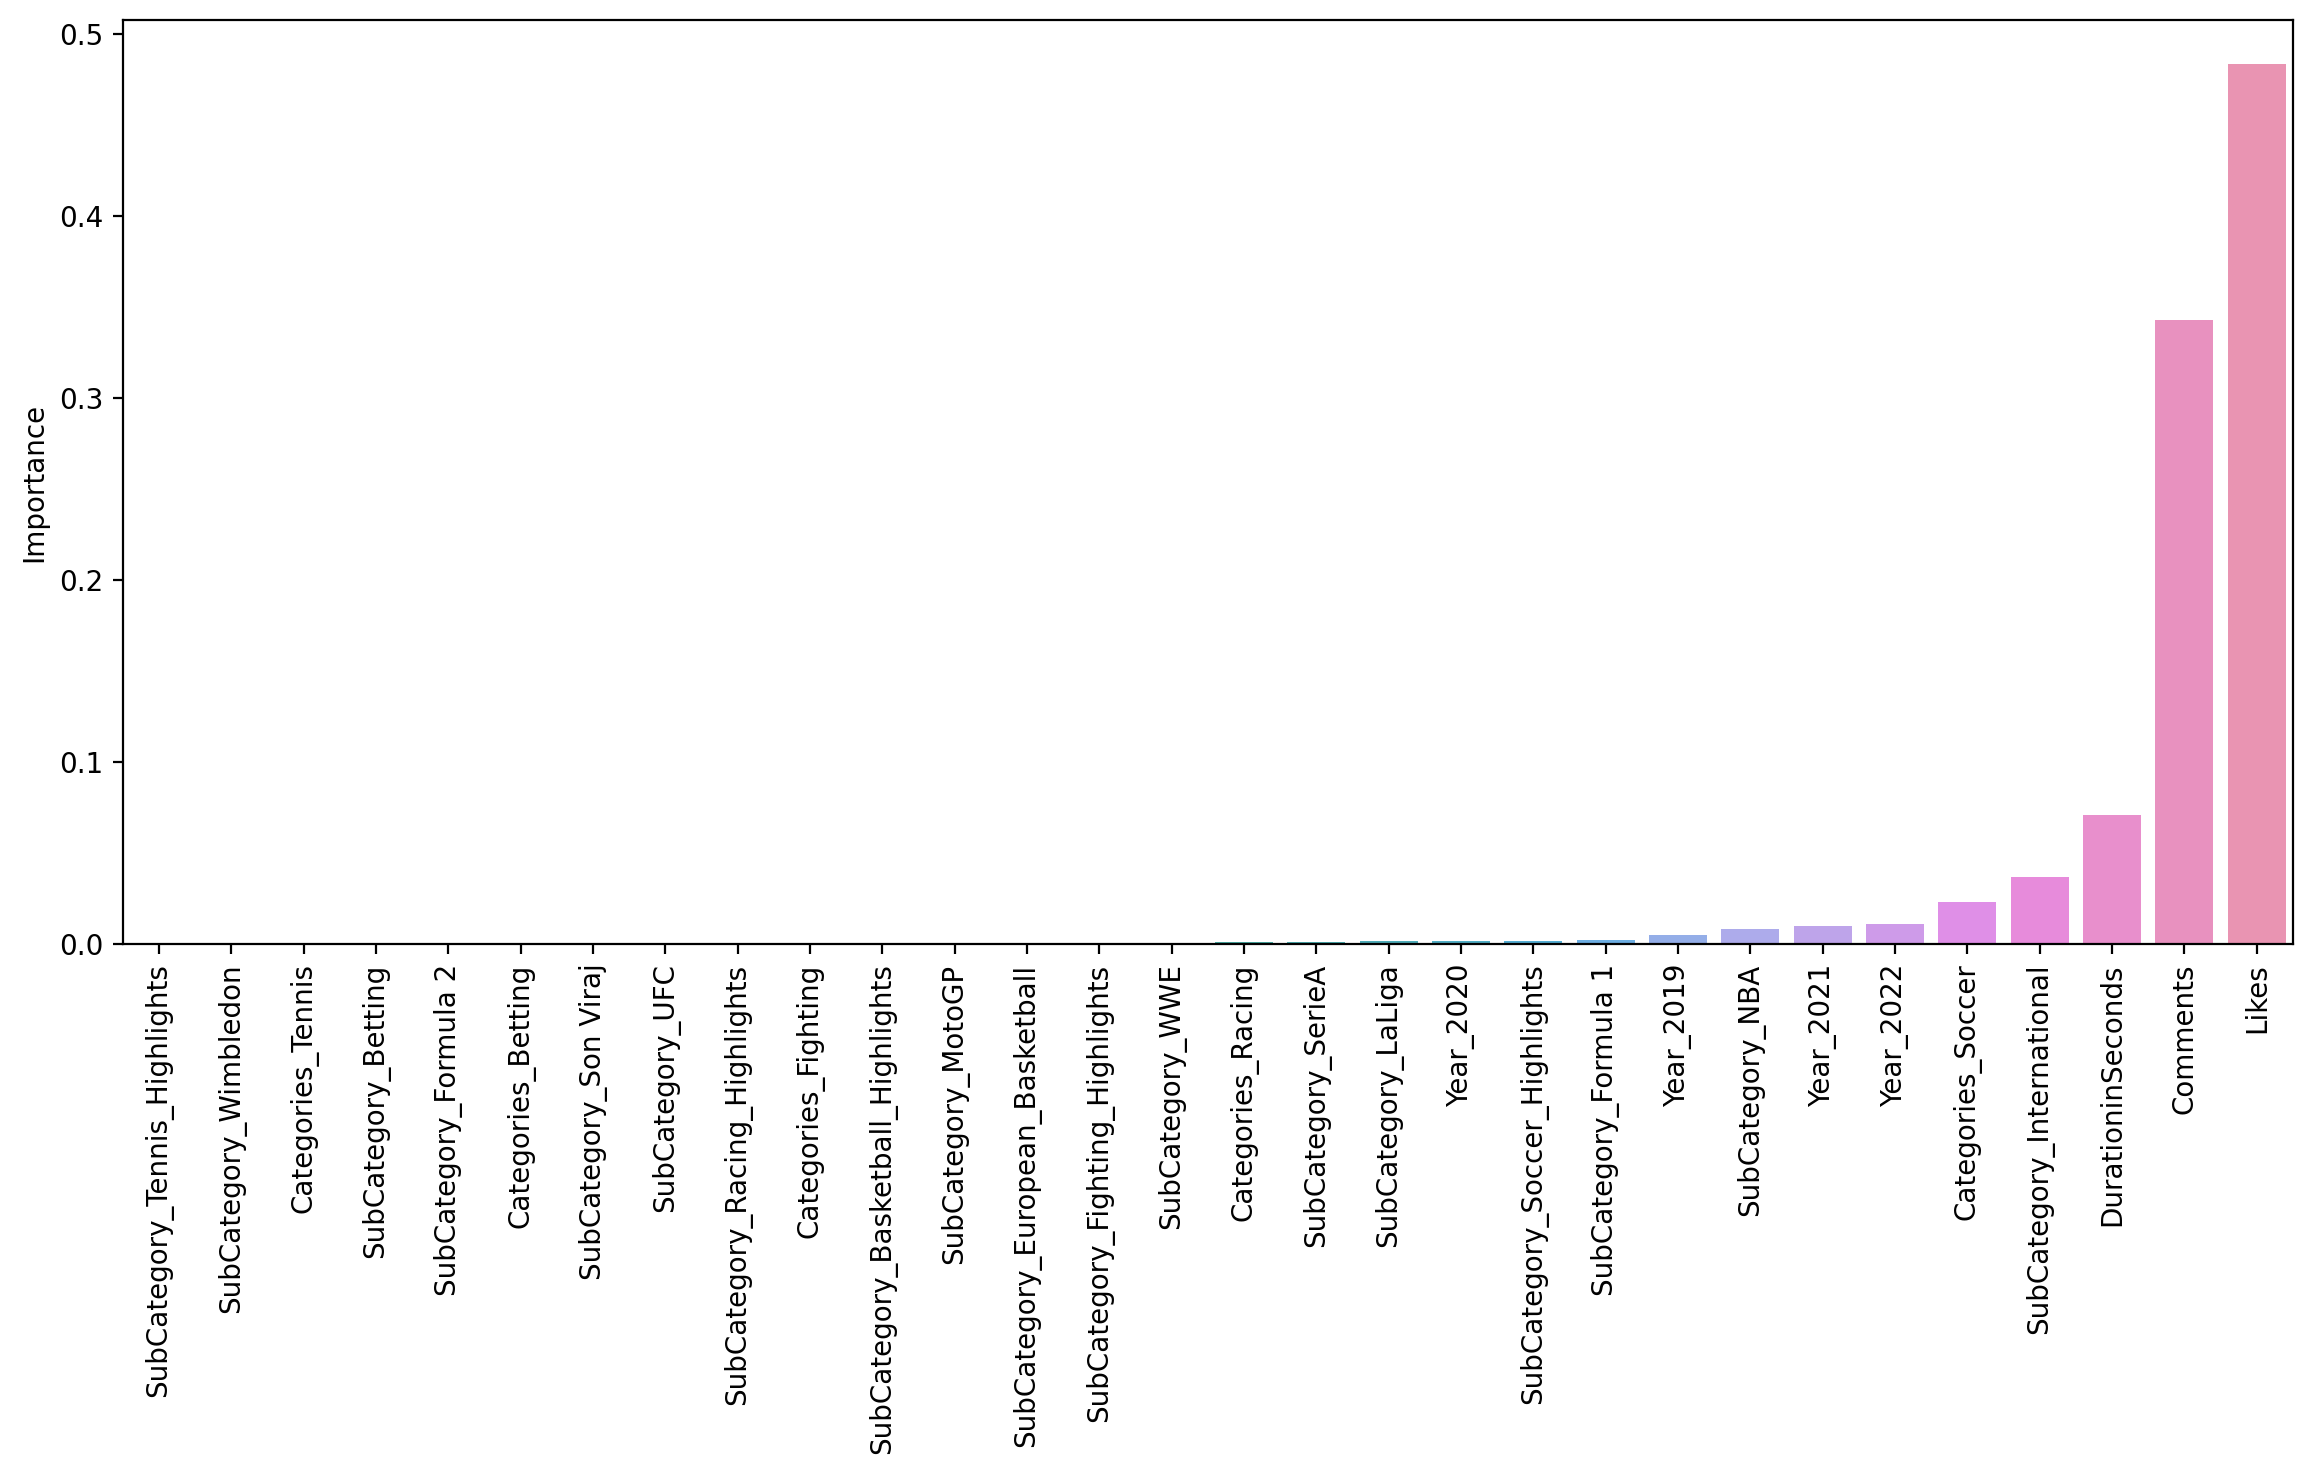

In [45]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=RF_imp_feats.sort_values('Importance'),x=RF_imp_feats.sort_values('Importance').index,y='Importance')
plt.xticks(rotation=90);

In [89]:
Importance_04_11_22_RF = RF_imp_feats.sort_values("Importance",ascending=False)

In [50]:
Importance_04_11_22_RF.to_csv('csv/Importance_04-11-22_RF_index.csv')

In [84]:
Importance_04_11_22_RF

,Importance
Likes,4.837271e-01
Comments,3.428900e-01
DurationinSeconds,7.048635e-02
SubCategory_International,3.692080e-02
Categories_Soccer,2.287931e-02
Year_2022,1.096684e-02
Year_2021,9.675993e-03
SubCategory_NBA,7.915763e-03
Year_2019,5.005369e-03
SubCategory_Formula 1,1.775404e-03


In [90]:
df = Importance_04_11_22_RF

In [91]:
df

,Importance
Likes,4.837271e-01
Comments,3.428900e-01
DurationinSeconds,7.048635e-02
SubCategory_International,3.692080e-02
Categories_Soccer,2.287931e-02
Year_2022,1.096684e-02
Year_2021,9.675993e-03
SubCategory_NBA,7.915763e-03
Year_2019,5.005369e-03
SubCategory_Formula 1,1.775404e-03


In [94]:
df.reset_index(inplace=True)
df = df.rename(columns = {'index':'value'})

In [95]:
df

,value,Importance
0,Likes,4.837271e-01
1,Comments,3.428900e-01
2,DurationinSeconds,7.048635e-02
3,SubCategory_International,3.692080e-02
4,Categories_Soccer,2.287931e-02
5,Year_2022,1.096684e-02
6,Year_2021,9.675993e-03
7,SubCategory_NBA,7.915763e-03
8,Year_2019,5.005369e-03
9,SubCategory_Formula 1,1.775404e-03


In [96]:
df.to_csv('csv/Importance_04-11-22_RF_df.csv')

In [52]:
Importance_04_11_22_RF.index

Index(['Likes', 'Comments', 'DurationinSeconds', 'SubCategory_International',
       'Categories_Soccer', 'Year_2022', 'Year_2021', 'SubCategory_NBA',
       'Year_2019', 'SubCategory_Formula 1', 'SubCategory_Soccer_Highlights',
       'Year_2020', 'SubCategory_LaLiga', 'SubCategory_SerieA',
       'Categories_Racing', 'SubCategory_WWE',
       'SubCategory_Fighting_Highlights', 'SubCategory_European_Basketball',
       'SubCategory_MotoGP', 'SubCategory_Basketball_Highlights',
       'Categories_Fighting', 'SubCategory_Racing_Highlights',
       'SubCategory_UFC', 'SubCategory_Son Viraj', 'Categories_Betting',
       'SubCategory_Formula 2', 'SubCategory_Betting', 'Categories_Tennis',
       'SubCategory_Wimbledon', 'SubCategory_Tennis_Highlights'],
      dtype='object')

In [49]:
Importance_04_11_22_RF

,Importance
Likes,4.837271e-01
Comments,3.428900e-01
DurationinSeconds,7.048635e-02
SubCategory_International,3.692080e-02
Categories_Soccer,2.287931e-02
Year_2022,1.096684e-02
Year_2021,9.675993e-03
SubCategory_NBA,7.915763e-03
Year_2019,5.005369e-03
SubCategory_Formula 1,1.775404e-03


In [48]:
with open('scaler_04-11-22.pickle','wb') as f:
    pickle.dump(scaler,f)

In [40]:
with open('models/model_04-11-22_new_RF.pickle','wb') as f:
    pickle.dump(RF_grid,f)

# Ada Boost

In [41]:
AB_model = AdaBoostRegressor()
AB_param_grid = {'n_estimators':[5,10,20,30,50,64,100,128,150],
              'loss':['linear', 'square', 'exponential']
             }
AB_grid = GridSearchCV(AB_model,param_grid=AB_param_grid,cv=5,verbose=2,scoring='neg_mean_squared_error')
AB_grid.fit(X_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] loss=linear, n_estimators=5 .....................................
[CV] ...................... loss=linear, n_estimators=5, total=   0.1s
[CV] loss=linear, n_estimators=5 .....................................
[CV] ...................... loss=linear, n_estimators=5, total=   0.0s
[CV] loss=linear, n_estimators=5 .....................................
[CV] ...................... loss=linear, n_estimators=5, total=   0.0s
[CV] loss=linear, n_estimators=5 .....................................
[CV] ...................... loss=linear, n_estimators=5, total=   0.0s
[CV] loss=linear, n_estimators=5 .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ...................... loss=linear, n_estimators=5, total=   0.0s
[CV] loss=linear, n_estimators=10 ....................................
[CV] ..................... loss=linear, n_estimators=10, total=   0.1s
[CV] loss=linear, n_estimators=10 ....................................
[CV] ..................... loss=linear, n_estimators=10, total=   0.1s
[CV] loss=linear, n_estimators=10 ....................................
[CV] ..................... loss=linear, n_estimators=10, total=   0.1s
[CV] loss=linear, n_estimators=10 ....................................
[CV] ..................... loss=linear, n_estimators=10, total=   0.1s
[CV] loss=linear, n_estimators=10 ....................................
[CV] ..................... loss=linear, n_estimators=10, total=   0.1s
[CV] loss=linear, n_estimators=20 ....................................
[CV] ..................... loss=linear, n_estimators=20, total=   0.2s
[CV] loss=linear, n_estimators=20 ....................................
[CV] .

[CV] ..................... loss=square, n_estimators=30, total=   0.2s
[CV] loss=square, n_estimators=30 ....................................
[CV] ..................... loss=square, n_estimators=30, total=   0.2s
[CV] loss=square, n_estimators=30 ....................................
[CV] ..................... loss=square, n_estimators=30, total=   0.2s
[CV] loss=square, n_estimators=50 ....................................
[CV] ..................... loss=square, n_estimators=50, total=   0.4s
[CV] loss=square, n_estimators=50 ....................................
[CV] ..................... loss=square, n_estimators=50, total=   0.4s
[CV] loss=square, n_estimators=50 ....................................
[CV] ..................... loss=square, n_estimators=50, total=   0.3s
[CV] loss=square, n_estimators=50 ....................................
[CV] ..................... loss=square, n_estimators=50, total=   0.4s
[CV] loss=square, n_estimators=50 ....................................
[CV] .

[CV] ............... loss=exponential, n_estimators=100, total=   0.7s
[CV] loss=exponential, n_estimators=100 ..............................
[CV] ............... loss=exponential, n_estimators=100, total=   0.7s
[CV] loss=exponential, n_estimators=100 ..............................
[CV] ............... loss=exponential, n_estimators=100, total=   0.8s
[CV] loss=exponential, n_estimators=100 ..............................
[CV] ............... loss=exponential, n_estimators=100, total=   0.7s
[CV] loss=exponential, n_estimators=100 ..............................
[CV] ............... loss=exponential, n_estimators=100, total=   0.7s
[CV] loss=exponential, n_estimators=128 ..............................
[CV] ............... loss=exponential, n_estimators=128, total=   0.9s
[CV] loss=exponential, n_estimators=128 ..............................
[CV] ............... loss=exponential, n_estimators=128, total=   0.9s
[CV] loss=exponential, n_estimators=128 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:   49.4s finished


GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [5, 10, 20, 30, 50, 64, 100, 128,
                                          150]},
             scoring='neg_mean_squared_error', verbose=2)

In [42]:
AB_grid.best_params_

{'loss': 'linear', 'n_estimators': 5}

In [43]:
AB_y_pred = AB_grid.predict(X_test)

AB_MAE = mean_absolute_error(y_test,AB_y_pred)
AB_MSE = mean_squared_error(y_test,AB_y_pred)
AB_RMSE = np.sqrt(AB_MSE)

print(AB_MAE)
print(AB_RMSE)

11657.600453051704
32660.118890868365


# GradientBoostingRegressor

In [11]:
GBR_model = GradientBoostingRegressor()
GBR_param_grid = {'n_estimators':[5,10,20,30,50,64,100,128,150,175,200],
              'max_features': [1,2,3,4,5,6,7,8,9,10],
              'max_depth':[1,2,3,4,5,6]
             }
GBR_grid = GridSearchCV(GBR_model,param_grid=GBR_param_grid,cv=10,verbose=1,scoring='neg_mean_squared_error')
GBR_grid.fit(X_train,y_train)

Fitting 10 folds for each of 660 candidates, totalling 6600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 6600 out of 6600 | elapsed: 17.9min finished


GridSearchCV(cv=10, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6],
                         'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 10, 20, 30, 50, 64, 100, 128, 150,
                                          175, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [15]:
GBR_grid.best_params_

{'max_depth': 4, 'max_features': 9, 'n_estimators': 128}

In [14]:
GBR_y_pred = GBR_grid.predict(X_test)

GBR_MAE = mean_absolute_error(y_test,GBR_y_pred)
GBR_MSE = mean_squared_error(y_test,GBR_y_pred)
GBR_RMSE = np.sqrt(GBR_MSE)

print(GBR_MAE)
print(GBR_RMSE)

6722.59511903584
30034.72092627475


In [16]:
GBR_feat_import = GBR_grid.best_estimator_.feature_importances_

In [17]:
GBR_imp_feats = pd.DataFrame(index=X.columns,data=GBR_feat_import,columns=['Importance'])

In [19]:
GBR_imp_feats.sort_values("Importance",ascending=False)

,Importance
Comments,4.504743e-01
Likes,4.307556e-01
SubCategory_International,3.520664e-02
DurationinSeconds,3.434537e-02
Categories_Soccer,1.812993e-02
SubCategory_NBA,7.724262e-03
Year_2021,6.440287e-03
SubCategory_Soccer_Highlights,5.152937e-03
Year_2019,4.674165e-03
Year_2022,2.577208e-03


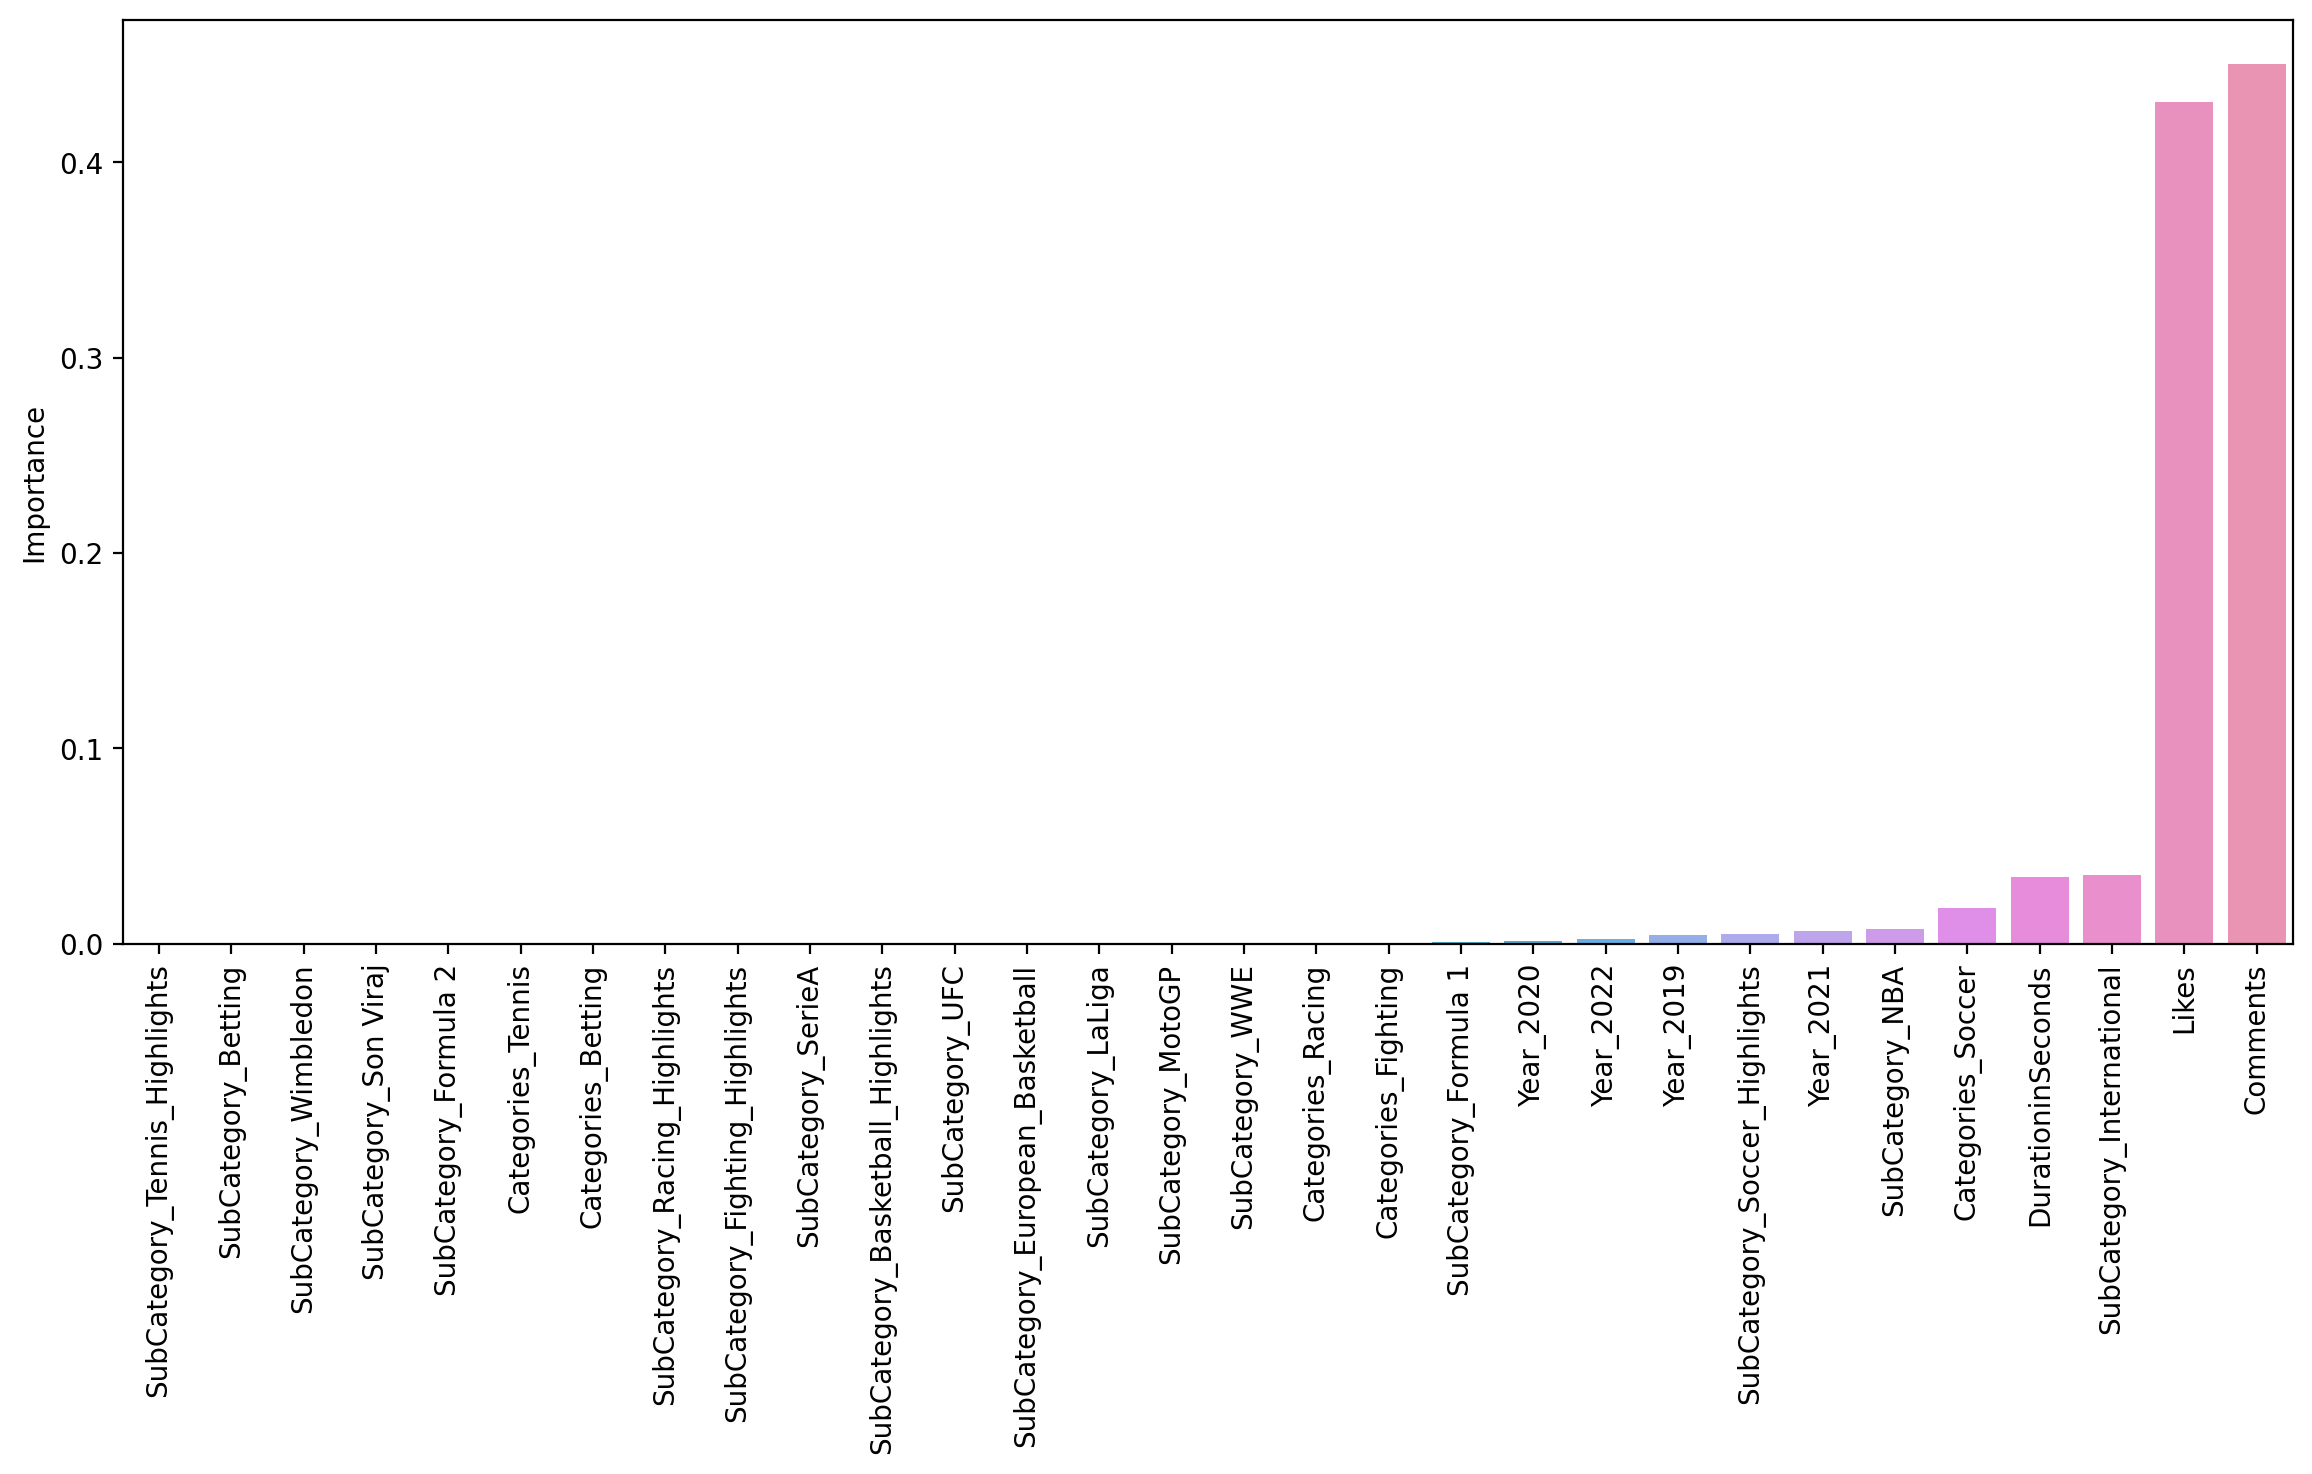

In [20]:
plt.figure(figsize=(14,6),dpi=200)
sns.barplot(data=GBR_imp_feats.sort_values('Importance'),x=GBR_imp_feats.sort_values('Importance').index,y='Importance')
plt.xticks(rotation=90);

In [22]:
Importance_04_11_22 = GBR_imp_feats.sort_values("Importance",ascending=False)

In [23]:
Importance_04_11_22

,Importance
Comments,4.504743e-01
Likes,4.307556e-01
SubCategory_International,3.520664e-02
DurationinSeconds,3.434537e-02
Categories_Soccer,1.812993e-02
SubCategory_NBA,7.724262e-03
Year_2021,6.440287e-03
SubCategory_Soccer_Highlights,5.152937e-03
Year_2019,4.674165e-03
Year_2022,2.577208e-03


In [27]:
X.head()

,Likes,Comments,DurationinSeconds,Categories_Betting,Categories_Fighting,Categories_Racing,Categories_Soccer,Categories_Tennis,Year_2019,Year_2020,...,SubCategory_MotoGP,SubCategory_NBA,SubCategory_Racing_Highlights,SubCategory_SerieA,SubCategory_Soccer_Highlights,SubCategory_Son Viraj,SubCategory_Tennis_Highlights,SubCategory_UFC,SubCategory_WWE,SubCategory_Wimbledon
0,14,0,78,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,4,0,96,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,7,2,123,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,70,8,549,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,299,99,499,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
X.columns

Index(['Likes', 'Comments', 'DurationinSeconds', 'Categories_Betting',
       'Categories_Fighting', 'Categories_Racing', 'Categories_Soccer',
       'Categories_Tennis', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022',
       'SubCategory_Basketball_Highlights', 'SubCategory_Betting',
       'SubCategory_European_Basketball', 'SubCategory_Fighting_Highlights',
       'SubCategory_Formula 1', 'SubCategory_Formula 2',
       'SubCategory_International', 'SubCategory_LaLiga', 'SubCategory_MotoGP',
       'SubCategory_NBA', 'SubCategory_Racing_Highlights',
       'SubCategory_SerieA', 'SubCategory_Soccer_Highlights',
       'SubCategory_Son Viraj', 'SubCategory_Tennis_Highlights',
       'SubCategory_UFC', 'SubCategory_WWE', 'SubCategory_Wimbledon'],
      dtype='object')

In [30]:
df['Views'].mean()

25762.012557603688